# ARIMAX model
ARMA + EEG as *endog* variable

In [1]:

# Import libraries
import logging
import os
import os.path as op
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

from subject_number import subject_number
import neurokit2 as nk

from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics as metrics
from pmdarima.arima import auto_arima

c:\Users\dadam\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-01\eeg\sub-01_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
567 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/3836909488.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


01


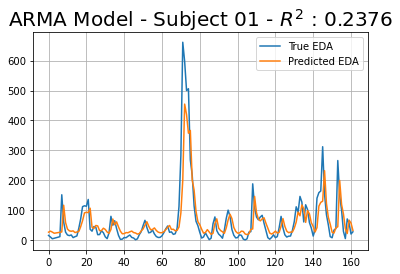

In [2]:


performance_r2 = []
for subject in ['01']: #, '02', '03', '04', '05']: #subject_number:
    bp = 'C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-' + subject  +'/eeg/sub-' + subject +'_task-rest_proc-EDA_epoRejected.fif'

    # read epochs

    epochs = mne.read_epochs(bp,
                            proj=False,
                            preload=True)

    epochs_eda = epochs.copy().pick_channels(ch_names=['EDA_Phasic', 'EDA_Tonic', 'EDA_SMNA', 'EDA'])


    EDA_mean = epochs.get_data().mean(axis=2) # keep 3 EDA means
    EDA_var = epochs.get_data().var(axis=2) # keep 3 EDA vars
    EDA_features_ndarray = np.hstack((EDA_mean,EDA_var))
    df_EDA_features = pd.DataFrame(EDA_features_ndarray, columns = ['meanEDA_Phasic', 'meanEDA_Tonic',
                                    'meanEDA_SMNA', 'varEDA_Phasic',
                                    'varEDA_Tonic', 'varEDA_SMNA'])
    EDA_features = df_EDA_features.to_dict(orient = 'list')
    for key, value in EDA_features.items():
        EDA_features[key] = np.array(value)

    # Plot EDA_features['meanEDA_SMNA']
    y = EDA_features['meanEDA_SMNA']
    y = y[:len(y)-int(len(y)/20)]
    print(subject)
        
    # size -> size of train set (90% of data)
    size = int(len(y) * 0.70)
    # split into train (90% data) and test set (10% data)
    train, test = y[0:size], y[size:len(y)]

    prediction = []
    train = pd.DataFrame(train)
    data = train.values
    test = pd.DataFrame(test)
    for t in test.values:
        # SEGUIR DESDE ACA
        # CAMBIAR ESTO POR SARIMAX
        model = ARIMA(data, order=(1,0,0)).fit()
        model_y = model.forecast(steps=len(test))[0]
        prediction.append(model_y)
        data = np.append(data, t)
    test_ = pd.DataFrame(test)
    test_['predictions_wf'] = prediction
    
    performance_r2_sub = metrics.r2_score(test_.predictions_wf, test_[0])
    performance_r2.append(performance_r2_sub)

    plt.plot(test_[0], label='True EDA')
    plt.plot(test_.predictions_wf, label='Predicted EDA')
    
    plt.title(f'ARMA Model - Subject {subject} - $R^2$ : %.4f'% performance_r2_sub, fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()



### Try autoarima
SEGUIR DESDE ACA. OPTIMIZAR AUTOARIMA PARA QUE EN LA PRIMERA CORRIDA CALCULE LOS MEJORES PARAMETROS Y DESPUES SOLO LO APLIQUE.

In [3]:
performance_r2 = []
for subject in ['01']: #, '02', '03', '04', '05']: #subject_number:
    bp = 'C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-' + subject  +'/eeg/sub-' + subject +'_task-rest_proc-EDA_epoRejected.fif'

    # read epochs

    epochs = mne.read_epochs(bp,
                            proj=False,
                            preload=True)

    epochs_eda = epochs.copy().pick_channels(ch_names=['EDA_Phasic', 'EDA_Tonic', 'EDA_SMNA', 'EDA'])


    EDA_mean = epochs.get_data().mean(axis=2) # keep 3 EDA means
    EDA_var = epochs.get_data().var(axis=2) # keep 3 EDA vars
    EDA_features_ndarray = np.hstack((EDA_mean,EDA_var))
    df_EDA_features = pd.DataFrame(EDA_features_ndarray, columns = ['meanEDA_Phasic', 'meanEDA_Tonic',
                                    'meanEDA_SMNA', 'varEDA_Phasic',
                                    'varEDA_Tonic', 'varEDA_SMNA'])
    EDA_features = df_EDA_features.to_dict(orient = 'list')
    for key, value in EDA_features.items():
        EDA_features[key] = np.array(value)

    # Plot EDA_features['meanEDA_SMNA']
    y = EDA_features['meanEDA_SMNA']
    y = y[:len(y)-int(len(y)/20)]
    print(subject)
        
    # size -> size of train set (90% of data)
    size = int(len(y) * 0.70)
    # split into train (90% data) and test set (10% data)
    train, test = y[0:size], y[size:len(y)]

    prediction = []
    train = pd.DataFrame(train)
    data = train.values
    test = pd.DataFrame(test)
    for t in test.values:
        # Predict just first element of test set
        model_y = auto_arima(y = data, scoring='mse')
        model_y_params = model_y.get_params()
        print()
        
    #     model_y.fit_predict(y = data, X=None, n_periods=(len(test)))[0]
    #     prediction.append(model_y)
    #     data = np.append(data, t)
    # test_ = pd.DataFrame(test)
    # test_['predictions_wf'] = prediction
    
    # performance_r2_sub = metrics.r2_score(test_.predictions_wf, test_[0])
    # performance_r2.append(performance_r2_sub)

    # plt.plot(test_[0], label='True EDA')
    # plt.plot(test_.predictions_wf, label='Predicted EDA')
    
    # plt.title(f'AutoARIMA Model - Subject {subject} - $R^2$ : %.4f'% performance_r2_sub, fontsize=20)
    # plt.legend()
    # plt.grid(True)
    # plt.show()

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-01\eeg\sub-01_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
567 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/1275433934.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


01








































KeyboardInterrupt: 

SEGUIR DESDE ACA
- Ver como corrio lo de arriba. Funciono AutoARIMA? O tengo que aplicar SARIMAX model directamente?
### Open diag model to see how implement it inside SARIMAX model
En `compute_EDA_cvx_prediction_gamma.py` fijarme como se extrae los features del SPOC model (y fijarme si son one feature por filter o one filter por freq band. Si es el primer caso, este es el metodo deifnitivo) y:
1. Usar esos features del SPoC model como exog variables (idealmente dentro del modelo autoarima, si eso corrio bien arriba, y sino con ARIMAX)
2. Hacer lo mismo, probando con Riemann o Diag model
3. Hacer lo mismo pero utilizando la valoracion del arousal segun autoreporte (ver como hice en mi tesis para extraer esa info)

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-01\eeg\sub-01_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
567 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


01
(0, 1, 5)
<class 'tuple'>


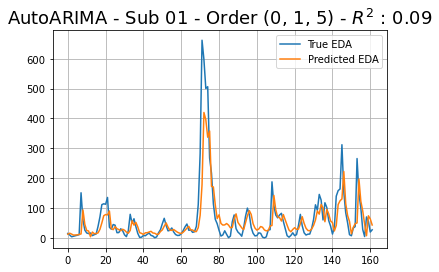

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-02\eeg\sub-02_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
490 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-02/eeg/sub-02_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


02
(1, 1, 1)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


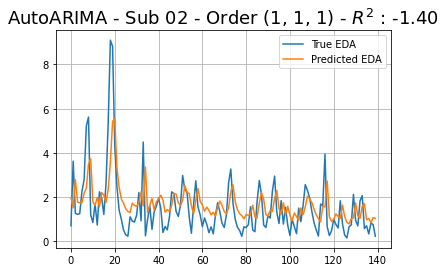

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-03\eeg\sub-03_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
503 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-03/eeg/sub-03_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


03
(1, 1, 1)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


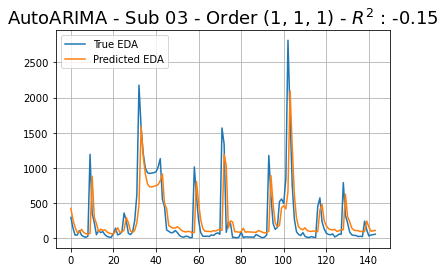

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-04\eeg\sub-04_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
590 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-04/eeg/sub-04_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


04
(0, 0, 1)
<class 'tuple'>


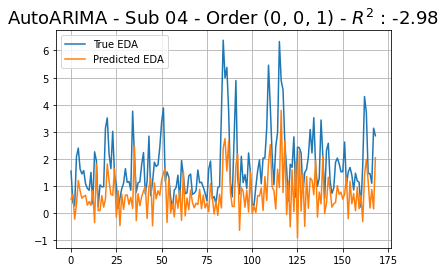

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-05\eeg\sub-05_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
568 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-05/eeg/sub-05_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


05
(1, 0, 1)
<class 'tuple'>


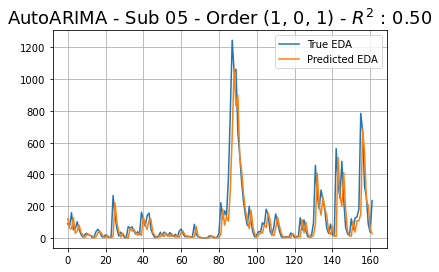

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-06\eeg\sub-06_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
592 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-06/eeg/sub-06_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


06
(0, 1, 0)
<class 'tuple'>


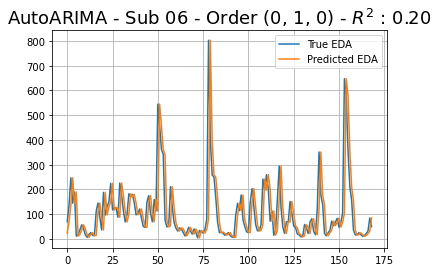

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-07\eeg\sub-07_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
592 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-07/eeg/sub-07_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


07
(1, 1, 1)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


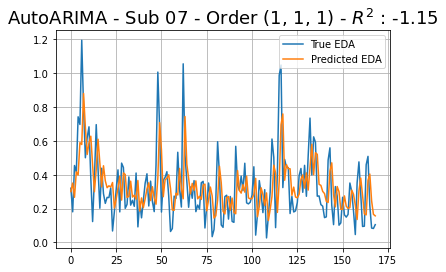

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-08\eeg\sub-08_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
234 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-08/eeg/sub-08_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


08
(1, 0, 0)
<class 'tuple'>


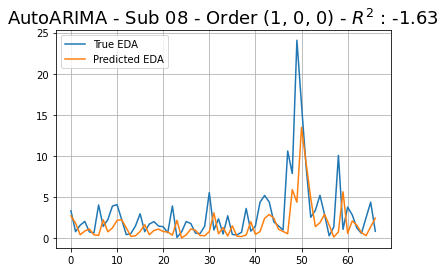

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-09\eeg\sub-09_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
591 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-09/eeg/sub-09_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


09
(0, 1, 2)
<class 'tuple'>


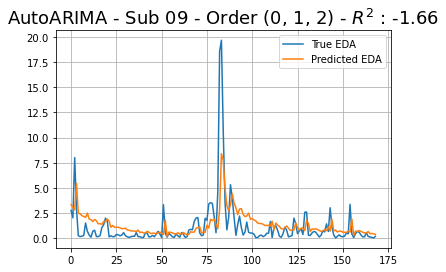

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-10\eeg\sub-10_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
600 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-10/eeg/sub-10_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


10
(2, 1, 2)
<class 'tuple'>


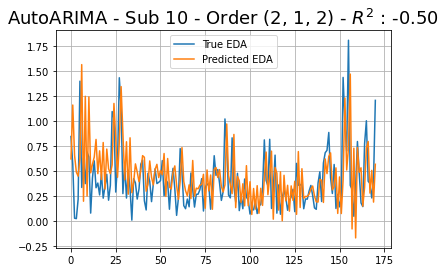

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-11\eeg\sub-11_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-11/eeg/sub-11_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


Not setting metadata
600 matching events found
No baseline correction applied
11
(3, 1, 2)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


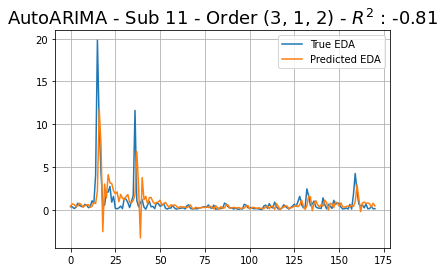

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-12\eeg\sub-12_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
599 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-12/eeg/sub-12_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


12
(1, 1, 1)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


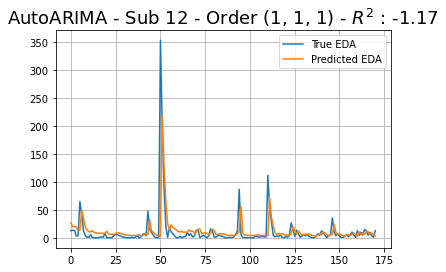

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-13\eeg\sub-13_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
601 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-13/eeg/sub-13_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


13
(2, 1, 1)
<class 'tuple'>


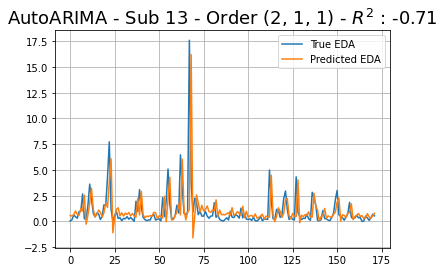

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-14\eeg\sub-14_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
604 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-14/eeg/sub-14_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


14
(2, 1, 3)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

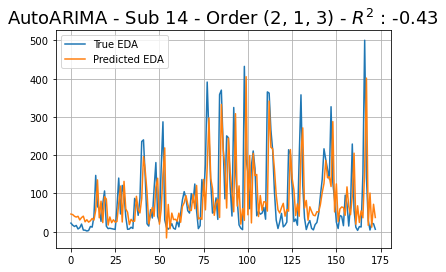

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-15\eeg\sub-15_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
320 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-15/eeg/sub-15_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


15
(0, 1, 1)
<class 'tuple'>


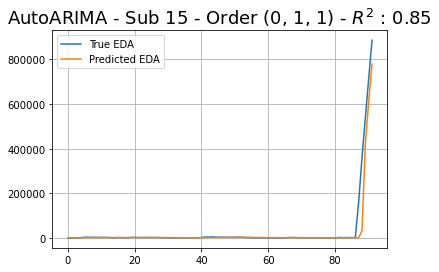

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-16\eeg\sub-16_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
410 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-16/eeg/sub-16_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


16
(0, 1, 5)
<class 'tuple'>


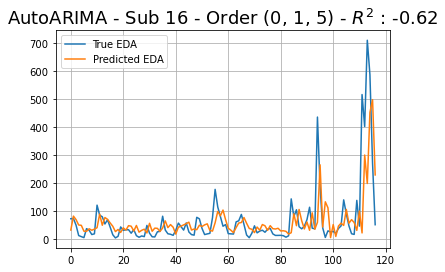

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-17\eeg\sub-17_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
151 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-17/eeg/sub-17_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


17
(1, 0, 0)
<class 'tuple'>


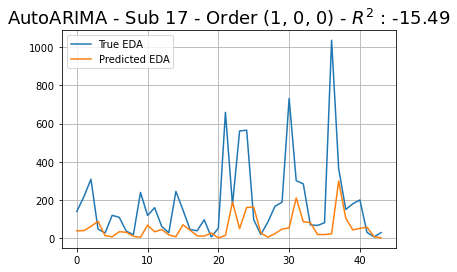

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-18\eeg\sub-18_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
585 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-18/eeg/sub-18_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


18
(0, 1, 3)
<class 'tuple'>


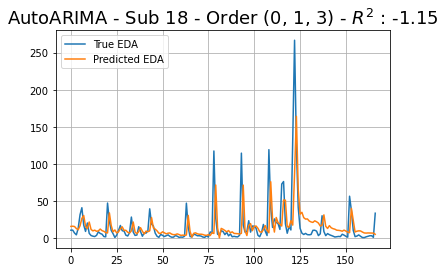

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-19\eeg\sub-19_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
579 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-19/eeg/sub-19_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


19
(1, 0, 2)
<class 'tuple'>


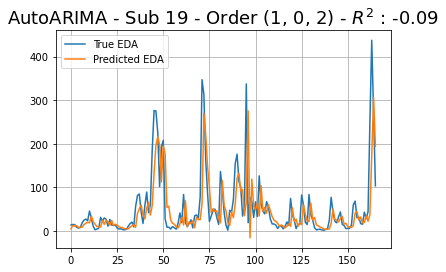

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-20\eeg\sub-20_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
580 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-20/eeg/sub-20_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


20
(1, 1, 1)
<class 'tuple'>


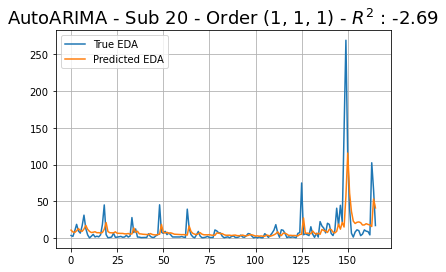

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-21\eeg\sub-21_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
601 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-21/eeg/sub-21_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


21
(0, 1, 0)
<class 'tuple'>


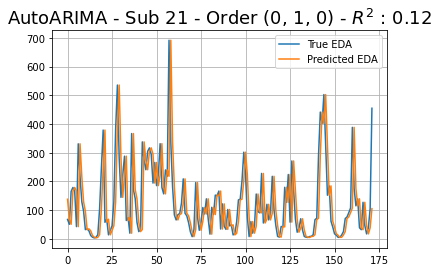

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-22\eeg\sub-22_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
525 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-22/eeg/sub-22_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


22
(1, 0, 1)
<class 'tuple'>


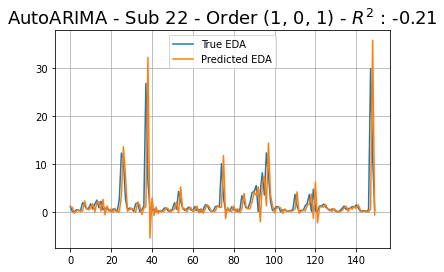

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-23\eeg\sub-23_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
598 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-23/eeg/sub-23_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


23
(3, 0, 2)
<class 'tuple'>


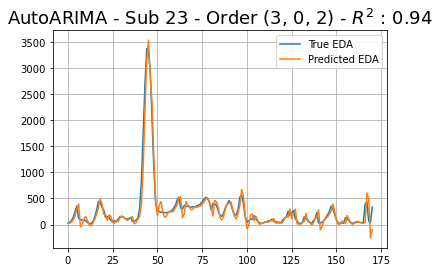

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-24\eeg\sub-24_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
565 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-24/eeg/sub-24_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


24
(1, 0, 0)
<class 'tuple'>


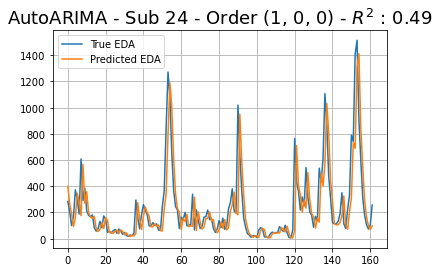

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-25\eeg\sub-25_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
312 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-25/eeg/sub-25_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


25
(1, 0, 0)
<class 'tuple'>


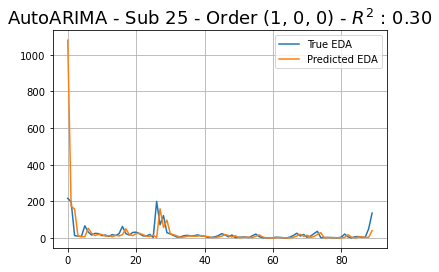

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-26\eeg\sub-26_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
149 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-26/eeg/sub-26_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


26
(1, 0, 0)
<class 'tuple'>


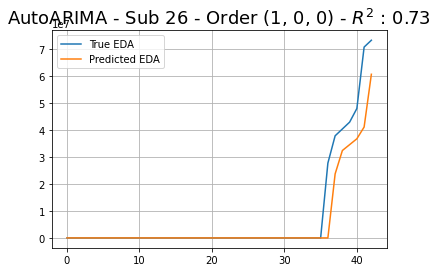

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-27\eeg\sub-27_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
593 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-27/eeg/sub-27_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


27
(0, 0, 3)
<class 'tuple'>


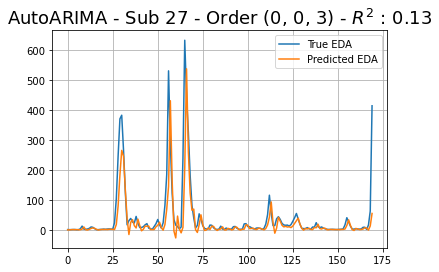

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-28\eeg\sub-28_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
457 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-28/eeg/sub-28_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


28
(1, 1, 1)
<class 'tuple'>


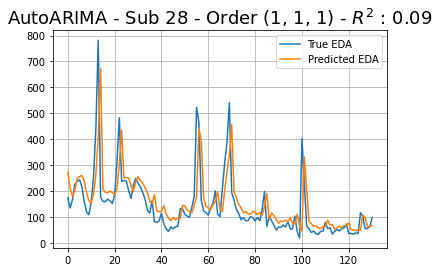

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-29\eeg\sub-29_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
567 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-29/eeg/sub-29_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


29
(0, 1, 0)
<class 'tuple'>


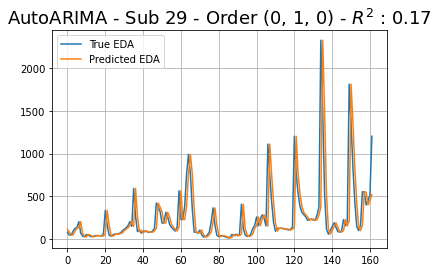

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-30\eeg\sub-30_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
359 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-30/eeg/sub-30_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


30
(1, 0, 1)
<class 'tuple'>


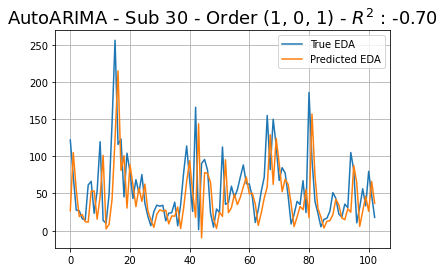

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-31\eeg\sub-31_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
526 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-31/eeg/sub-31_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


31
(0, 2, 2)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


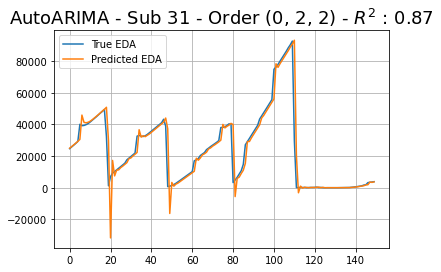

Reading C:\Users\dadam\arousal_project\arousal_decoding_extended\outputs\DEAP-bids\derivatives\mne-bids-pipeline\sub-32\eeg\sub-32_task-rest_proc-EDA_epoRejected.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
594 matching events found
No baseline correction applied


C:\Users\dadam\AppData\Local\Temp/ipykernel_18856/4274563004.py:7: RuntimeWarning: This filename (C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-32/eeg/sub-32_task-rest_proc-EDA_epoRejected.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(bp,


32
(3, 0, 1)
<class 'tuple'>


c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dadam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

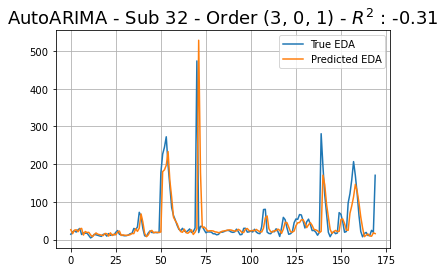

In [42]:
performance_r2 = []
for subject in subject_number: #['01']: #, '02', '03', '04', '05']: #subject_number:
    bp = 'C:/Users/dadam/arousal_project/arousal_decoding_extended/outputs/DEAP-bids/derivatives/mne-bids-pipeline/sub-' + subject  +'/eeg/sub-' + subject +'_task-rest_proc-EDA_epoRejected.fif'

    # read epochs

    epochs = mne.read_epochs(bp,
                            proj=False,
                            preload=True)

    epochs_eda = epochs.copy().pick_channels(ch_names=['EDA_Phasic', 'EDA_Tonic', 'EDA_SMNA', 'EDA'])


    EDA_mean = epochs.get_data().mean(axis=2) # keep 3 EDA means
    EDA_var = epochs.get_data().var(axis=2) # keep 3 EDA vars
    EDA_features_ndarray = np.hstack((EDA_mean,EDA_var))
    df_EDA_features = pd.DataFrame(EDA_features_ndarray, columns = ['meanEDA_Phasic', 'meanEDA_Tonic',
                                    'meanEDA_SMNA', 'varEDA_Phasic',
                                    'varEDA_Tonic', 'varEDA_SMNA'])
    EDA_features = df_EDA_features.to_dict(orient = 'list')
    for key, value in EDA_features.items():
        EDA_features[key] = np.array(value)

    # Plot EDA_features['meanEDA_SMNA']
    y = EDA_features['meanEDA_SMNA']
    y = y[:len(y)-int(len(y)/20)]
    print(subject)
        
    # size -> size of train set (90% of data)
    size = int(len(y) * 0.70)
    # split into train (90% data) and test set (10% data)
    train, test = y[0:size], y[size:len(y)]

    prediction = []
    prediction_ci = []
    train = pd.DataFrame(train)
    data = train.values
    test = pd.DataFrame(test)
    model_y = auto_arima(y = data, scoring='mse')
    model_y_params_order = model_y.get_params()['order']
    print(model_y_params_order)
    print(type(model_y_params_order))
    for t in test.values:
        # Predict just first element of test set
        result = SARIMAX(endog = data, order=model_y_params_order).fit()
        pred = result.get_forecast(steps=1)
        #print(pred.predicted_mean)
        pred_ci = pred.conf_int()
        #print(pred_ci)
        prediction.append(pred.predicted_mean)
        prediction_ci.append(pred_ci)
        data = np.append(data, t)
    test_ = pd.DataFrame(test)
    test_['predictions_wf'] = prediction
    
    performance_r2_sub = metrics.r2_score(test_.predictions_wf, test_[0])
    performance_r2.append(performance_r2_sub)

    plt.plot(test_[0], label='True EDA')
    plt.plot(test_.predictions_wf, label='Predicted EDA')
        
    #ax.fill_between(len(prediction_ci),
    #            prediction_ci_low,
    #            prediction_ci_high, alpha=.2)
    
    plt.title(f'AutoARIMA - Sub {subject} - Order {model_y_params_order} - $R^2$ : %.2f'% performance_r2_sub, fontsize=18)
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
prediction_ci_low = [i[0][0] for i in prediction_ci]
prediction_ci_high = [i[0][0] for i in prediction_ci]